# Chronos-2 Foundation Model
In this notebook, we will show how to use Chronos-2 in Darts. If you are new to Darts, please check out the [Quickstart Guide](https://unit8co.github.io/darts/quickstart/00-quickstart.html) before proceeding.

Chronos-2 is a time series foundation model for zero-shot forecasting. That means that it can be used for forecasting **without any training or fine-tuning** since it has already been pre-trained on large-scale time series data. Chronos-2 supports multivariate time series forecasting with [covariates](https://unit8co.github.io/darts/userguide/covariates.html) (exogenous variables) and can produce probabilistic forecasts.

Check out the [Amazon Science Blog](https://www.amazon.science/blog/introducing-chronos-2-from-univariate-to-universal-forecasting) and the [original paper](https://arxiv.org/abs/2510.15821) for technical details.

<div class="alert alert-success" role="alert">
  Fine-tuning Chronos-2 on your own data is not yet supported in Darts, but may be added in the future.
</div>

In [23]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import warnings

import numpy as np

from darts.datasets import AirPassengersDataset
from darts.models import Chronos2Model

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Data Preparation

Here, we will use the [Electricity Consumption Zurich Dataset](https://unit8co.github.io/darts/generated_api/darts.datasets.html#darts.datasets.ElectricityConsumptionZurichDataset), which records the electricity consumption of households & SMEs (`"Value_NE5"` column) and business & services (`"Value_NE7"`) in Zurich, Switzerland, along with weather covariates such as temperature (`"T [°C]"`) and humidity (`"Hr [%Hr]"`).
Values are recorded every 15 minutes between January 2015 and August 2022.

<details>

<summary><strong>Train-Test Split</strong></summary>

Even though Chronos-2 is pre-trained already, we still need to split the data into training and test sets. That is because `Chronos2Model` follows the Darts unified interface and will require calling the `fit()` method before forecasting. However, no training or fine-tuning will be performed during the `fit()` call.

</details>

<details>

<summary><strong>Data Scaling</strong></summary>

Unlike other deep learning models in Darts, Chronos-2 does not require data scaling since it has its own internal data normalization mechanism. Therefore, we will skip the scaling step in this notebook.

</details>

In [26]:
# convert to float32 as Chronos-2 works with float32 input
data = AirPassengersDataset().load().astype(np.float32)
# extract households energy consumption
# ts_energy = data["Value_NE5"]
# # extract temperature, solar irradiation and rain duration
# ts_weather = data[["T [°C]", "StrGlo [W/m2]", "RainDur [min]"]]
# # split into train and validation sets by last 7 days
train_passengers, val_passengers = data.split_before(len(data) - 2 * 12)

In [27]:
val_passengers

,#Passengers
Month,
1959-01-01,360.0
1959-02-01,342.0
1959-03-01,406.0
1959-04-01,396.0
1959-05-01,420.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


Let's quickly visualize the last 7 days of the electricity consumption data.

<Axes: xlabel='Month'>

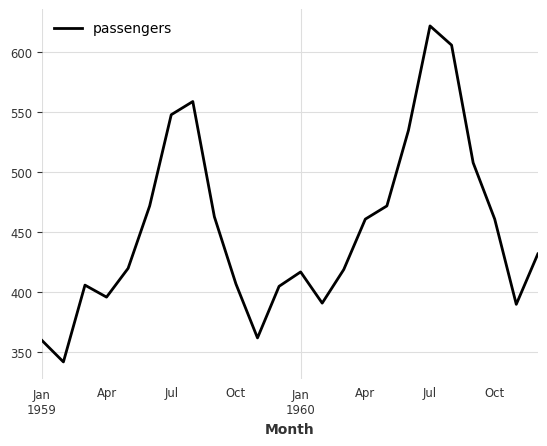

In [28]:
val_passengers.plot(label="passengers")

In [29]:
# use last 30 days of data to predict next 7 days
model = Chronos2Model(
    input_chunk_length=12,
    output_chunk_length=6,
    n_epochs=10,
    pl_trainer_kwargs={"accelerator": "mps"},
)

In [31]:
model.fit(
    series=train_passengers,
    verbose=True,
)

Chronos2Model(output_chunk_shift=0, likelihood=None, hub_model_name=amazon/chronos-2, hub_model_revision=None, local_dir=None, input_chunk_length=12, output_chunk_length=6, n_epochs=10, pl_trainer_kwargs={'accelerator': 'mps'})

Predicting: |          | 0/? [00:00<?, ?it/s]

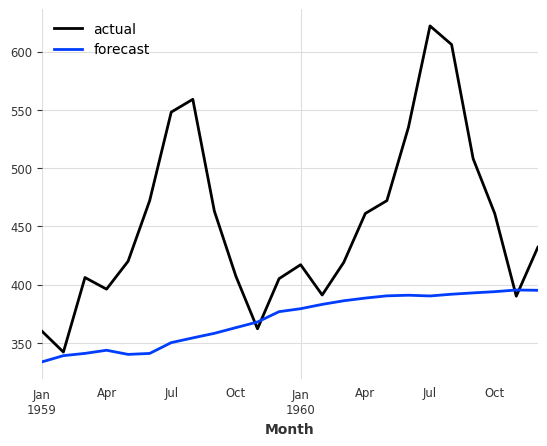

In [32]:
pred = model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="actual")
pred.plot(label="forecast");

In [33]:
model.model.model.state_dict()

OrderedDict([('shared.weight',
              tensor([[-1.4855e-06,  6.6741e-07, -2.3774e-07,  ...,  2.5759e-07,
                        1.6342e-06,  2.2832e-06],
                      [-2.4927e-03,  3.1087e-03,  1.2331e-03,  ..., -1.2153e-02,
                       -7.9643e-04, -9.8041e-03]])),
             ('input_patch_embedding.hidden_layer.weight',
              tensor([[-1.6344e-03, -1.7315e-03, -1.7230e-03,  ..., -6.8476e-03,
                       -1.5899e-03, -7.6784e-03],
                      [ 1.5054e-04,  1.0679e-04,  2.0166e-04,  ...,  3.2022e-03,
                        3.9019e-03,  3.4222e-03],
                      [-8.2940e-04, -8.7882e-04, -8.5499e-04,  ..., -3.6055e-03,
                       -5.0129e-03, -1.8745e-03],
                      ...,
                      [ 1.2615e-04,  1.2288e-04,  1.2020e-04,  ..., -4.6238e-05,
                       -5.1860e-05, -4.6755e-05],
                      [ 9.5315e-07,  9.7295e-07,  9.5850e-07,  ..., -1.6984e-06,
             

In [ ]:
from peft import LoraConfig, PeftModel, get_peft_model

In [35]:
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["v"],  # optionally indicate target modules
)

In [36]:
model.model.model = get_peft_model(model.model.model, peft_config)
model._enable_finetuning = True

In [37]:
model.fit(
    series=train_passengers,
    verbose=True,
)

Training: |          | 0/? [00:00<?, ?it/s]

Chronos2Model(output_chunk_shift=0, likelihood=None, hub_model_name=amazon/chronos-2, hub_model_revision=None, local_dir=None, input_chunk_length=12, output_chunk_length=6, n_epochs=10, pl_trainer_kwargs={'accelerator': 'mps'})

Predicting: |          | 0/? [00:00<?, ?it/s]

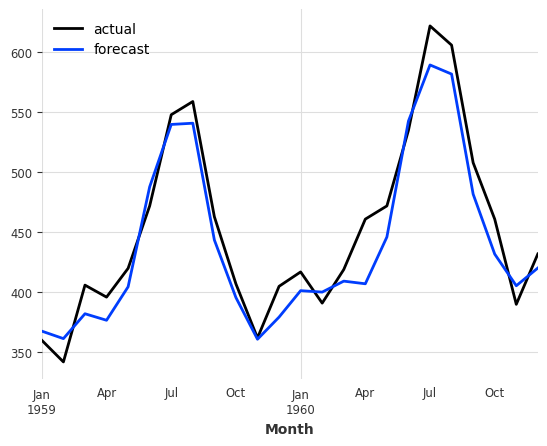

In [38]:
pred = model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="actual")
pred.plot(label="forecast");

In [39]:
model.model.model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 120,657,312 || trainable%: 0.9777


In [40]:
model.model.model.save_pretrained("chronos2-lora-passengers")

In [41]:
# use last 30 days of data to predict next 7 days
model_loaded = Chronos2Model(
    input_chunk_length=12,
    output_chunk_length=6,
    n_epochs=10,
    pl_trainer_kwargs={"accelerator": "mps"},
)

In [42]:
model_loaded.fit(
    series=train_passengers,
    verbose=True,
)

Chronos2Model(output_chunk_shift=0, likelihood=None, hub_model_name=amazon/chronos-2, hub_model_revision=None, local_dir=None, input_chunk_length=12, output_chunk_length=6, n_epochs=10, pl_trainer_kwargs={'accelerator': 'mps'})

In [43]:
model_loaded.model.model = PeftModel.from_pretrained(
    model_loaded.model.model, "chronos2-lora-passengers"
)

Predicting: |          | 0/? [00:00<?, ?it/s]

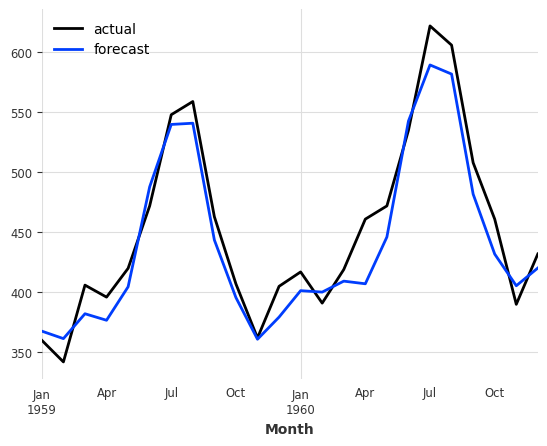

In [44]:
pred = model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="actual")
pred.plot(label="forecast");